In [1]:
%matplotlib inline

# Import custom scripts

In [2]:
path_scripts = '/mnt/kauffman/joosts/projects/STRT_epidermis/scripts'

In [3]:
import sys
sys.path.append(path_scripts)

In [4]:
from EPI_misc_scripts_v1_1 import *
from EPI_affinity_propagation_v1_0 import *
from EPI_neg_binom_regression_v1_1 import *
from EPI_pseudotemporal_ordering_v1_0 import *

Couldn't import dot_parser, loading of dot files will not be possible.


In [5]:
from matplotlib.gridspec import GridSpec
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import ward

# Initialize engines

In [6]:
from ipyparallel import Client

In [7]:
c = Client(profile='default')

In [8]:
dview = c[:]

In [9]:
dview.execute('import sys')
dview.execute('sys.path.append("/mnt/kauffman/joosts/projects/STRT_epidermis/scripts")')
dview.execute('from EPI_misc_scripts_v1_1 import *')
dview.execute('from EPI_affinity_propagation_v1_0 import *')
dview.execute('from EPI_neg_binom_regression_v1_1 import *')
dview.execute('from EPI_pseudotemporal_ordering_v1_0 import *')

<AsyncResult: finished>

# Import Data

In [10]:
exp_id = '201509151726'
path_input = '/mnt/kauffman/joosts/projects/STRT_epidermis/data_input/v1.8'
path_output = '/mnt/kauffman/joosts/projects/STRT_epidermis/data_output/v1.8'
path_figures = '/mnt/kauffman/joosts/projects/STRT_epidermis/figures/v1.8'

In [11]:
seq = loadData_v1(path_input, exp_id, 'seq', 'DataFrame')
meta = loadData_v1(path_input, exp_id, 'meta', 'DataFrame')

In [12]:
seq_sel_1st = loadData_v1(path_output, exp_id, 'seq_sel_1st', 'DataFrame')

In [13]:
s_groups_1st = loadData_v1(path_output, exp_id, 's_groups_1st', 'Series')
g_groups_1st = loadData_v1(path_output, exp_id, 'g_groups_1st', 'Series')

## Color maps

In [14]:
cmap_1st = {2:'#00CC00',
          1:'#FFE000',
          8:'#FF9900',
          0:'#FF3300',
          10:'#CC0000',
          6:'#cab2d6',
          3:'#A68BC2',
          4:'#65429A',
          5:'#000066',
          7:'#0066FF',
          9:'#33CCCC',
          11:'#FF99CC',
          12:'#660033'}

In [15]:
#Create colormap and colorlist for hair cycle stage data

cmap_hair_cycle = {'mid telogen (Ki67)': '#00CC00', 'late telogen (Ki67)': '#FFCC00'}

In [16]:
#Create colormap and colorlist for Sca1 data

cmap_Sca1 = {'1': '#FF0000', '0': '#0066FF'}

## Name maps

In [17]:
#Create namemap for sample groups:

nmap_1st = {2:'IFE basal cells (IFE B)',
          1:'IFE differentiated cells I (IFE DI)',
          8:'IFE differentiated cells II (IFE DII)',
          0:'IFE keratinized layer I (IFE KI)',
          10:'IFE keratinized layer II (IFE KII)',
          6:'Upper hair follicle I (uHF I)',
          3:'Upper hair follicle II (uHF II)',
          4:'Upper hair follicle III (uHF III)',
          5:'Sebaceous gland (SG)',
          7:'Outer bulge (OB)',
          9:'Inner bulge (IB)',
          11:'T cells (TC)',
          12:'Langerhans cells (LH)'}

In [18]:
nmap_1st_short = {2:'IFE B',
          1:'IFE DI',
          8:'IFE DII',
          0:'IFE KI',
          10:'IFE KII',
          6:'uHF I',
          3:'uHF II',
          4:'uHF III',
          5:'SG',
          7:'OB',
          9:'IB',
          11:'TC',
          12:'LH'}

In [19]:
gmap_1st = {2:'Krt14(hi), Mt2(hi)',
          1:'Krt10(dim), Ptgs1(dim)',
          8:'Krt10(hi), Ptgs1(hi)',
          0:'Lor(dim), Flg2(dim)',
          10:'Lor(hi), Flg2(hi)',
          6:'Krt79(low), Krt17(low)',
          3:'Krt79(dim), Krt17(dim)',
          4:'Krt79(hi), Krt17(hi)',
          5:'Mgst1(hi), Scd1(hi)',
          7:'Postn(hi), Cd34(hi)',
          9:'Krt6a(hi), Krt75(hi)',
          11:'Cd3(hi), Thy1(hi)',
          12:'Cd207(hi), Ctss(hi)'}

# Feature selection

In [18]:
seq_sel_1st = dropNull(seq, path_input, cutoff_mean = 0.05)


Dropping spikes from dataset

Dropping repeats from dataset

Dropping unexpressed genes from dataset


In [19]:
len(seq_sel_1st.index)

9168

In [20]:
seq_sel_1st = cellCutoff(seq_sel_1st, 2000)


Removing cells with less than 2000 transcripts


In [21]:
len(seq_sel_1st.columns)

1422


Dropping unexpressed genes from dataset

After mean expression cutoff of 0.05, 9164 genes remain

After correlation cutoff of 5, 7123 genes remain

Optimization terminated successfully.
         Current function value: 1826.072511
         Iterations: 29
         Function evaluations: 53

After high variance feature selection, 2500 genes remain

Calculating binary logarithm of x + 1


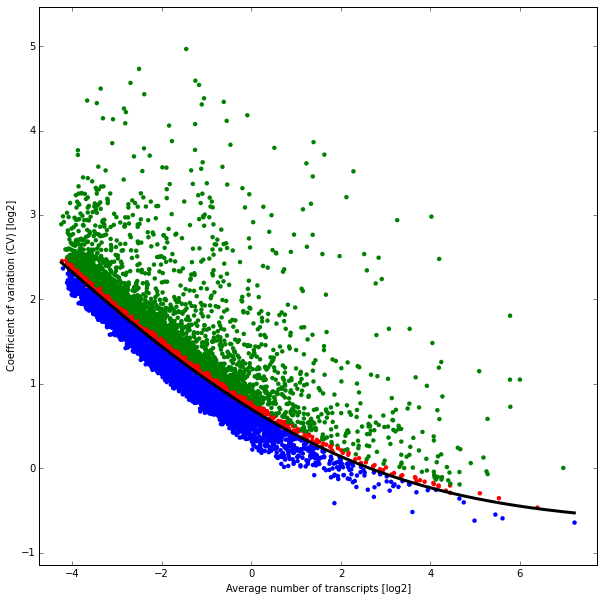

In [24]:
seq_sel_1st, corr_filt_1st, log2_cv_diff_1st, xopt_1st = select_features_v1(seq_sel_1st, 0.05, 5, 2500, path_input, percentile=95, 
                                 return_all=True, drop_spikes = False, drop_repeats = False)

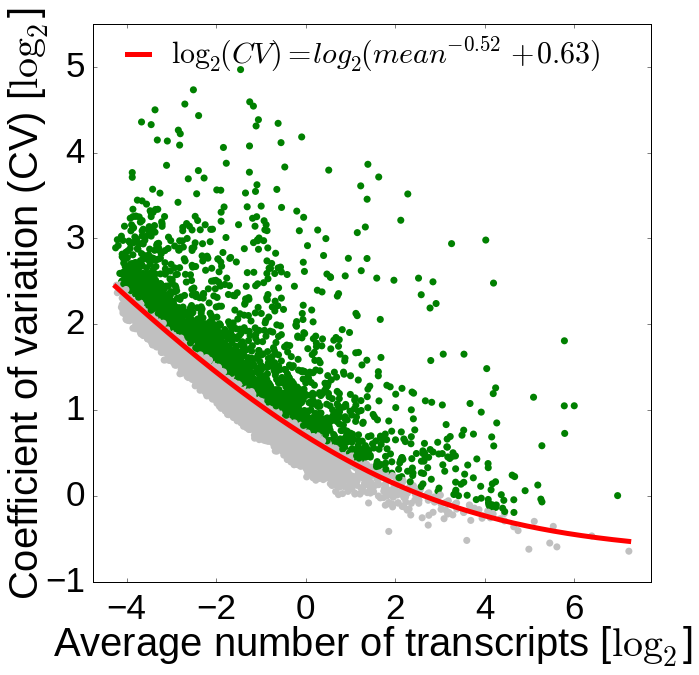

In [107]:
selected = seq_sel_1st.index

data_mean = seq.ix[log2_cv_diff_1st.index, s_groups_1st.index].mean(axis = 1)
data_cv = seq.ix[log2_cv_diff_1st.index, s_groups_1st.index].std(axis = 1) / data_mean

log2_mean = np.log2(data_mean)
log2_cv = np.log2(data_cv)
    
line_x = np.arange(log2_mean.min(), log2_mean.max(), 0.01)
line_y = np.log2(( 2 ** line_x) ** xopt_1st[0] + xopt_1st[1])
    
clist = pd.Series('silver', index = log2_mean.index)
clist[log2_cv_diff_1st[log2_cv_diff_1st > 0].index] = 'silver'
    
if np.all(selected) != None:
    clist[selected] = 'green'

fig = plt.figure(figsize = [10,10], facecolor = 'w')
ax0 = plt.axes()
    
ax0.set_xlabel('Average number of transcripts [$\log_2$]', family = 'Liberation Sans', fontsize = 40)
ax0.xaxis.set_label_coords(x = 0.5, y = -0.075)
for tick in ax0.xaxis.get_major_ticks():
                tick.label.set_fontsize(35) 
                tick.label.set_family('Liberation Sans')
ax0.tick_params(axis='x', which='major', pad=10)

ax0.set_ylabel('Coefficient of variation (CV) [$\log_2$]', family = 'Liberation Sans', fontsize = 40)
ax0.yaxis.set_label_coords(y = 0.5, x = -0.075)
for tick in ax0.yaxis.get_major_ticks():
                tick.label.set_fontsize(35) 
                tick.label.set_family('Liberation Sans')
ax0.tick_params(axis='y', which='major', pad=10)
    
ax0.set_xlim(log2_mean.min() - 0.5, log2_mean.max() + 0.5)
ax0.set_ylim(-1, 5.5)
    
ax0.scatter(log2_mean, log2_cv, c = clist, linewidth = 0, s= 50, edgecolor = clist)
ax0.plot(line_x, line_y, c = 'r', linewidth = 5)

ax0.text(-3, 5.15, '$\log_{2}(CV) = log_{2}(mean^{-0.52}+0.63)$', family = 'Liberation Sans', fontsize = 30, va = 'center')
ax0.plot([-4, -3.5], [5.15, 5.15], c = 'r', linewidth = 5)

figname = 'v1.8_S2_A_Feature_selection.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# Cell-cell distance matrix

In [35]:
seq_s_corr = log2Transform(seq).ix[g_groups_1st.index, s_groups_1st.index].corr()


Calculating binary logarithm of x + 1


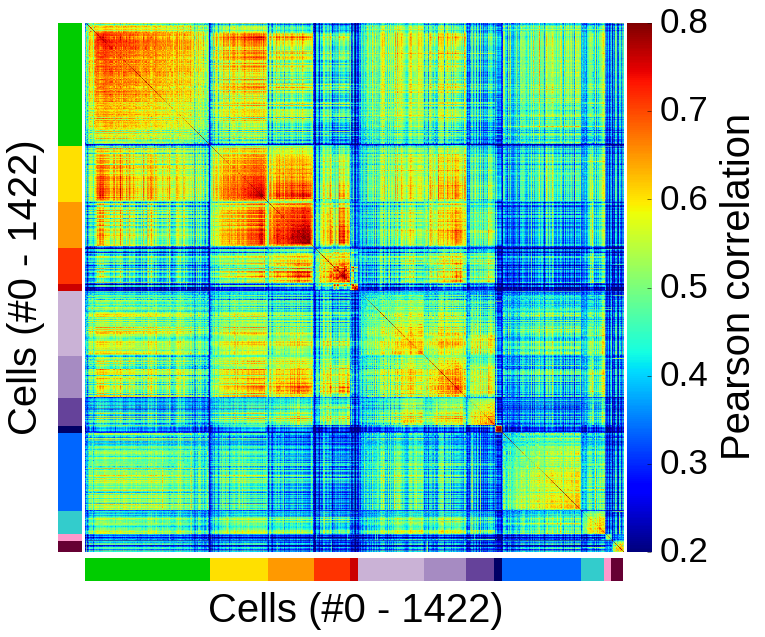

In [110]:
cmap = plt.cm.jet

#generate figure

fig = plt.figure(facecolor = 'w', figsize = (10.625, 10))
gs = plt.GridSpec(nrows = 2, ncols = 3, wspace=0.02, hspace=0.02, width_ratios=[0.5 , 11.25, 0.5], height_ratios=[11.25, 0.5])

#plot heatmap

axHM = plt.subplot(gs[0, 1])

axHM.matshow(seq_s_corr, cmap = cmap, aspect = 'auto', vmin = 0.2, vmax = 0.8, interpolation = None)
    
axHM.set_xlabel('Cells (#0 - %s)' % len(s_groups_1st), family = 'Liberation Sans', fontsize = 40)
axHM.set_ylabel('Cells (#0 - %s)' % len(s_groups_1st), family = 'Liberation Sans', fontsize = 40)

axHM.xaxis.set_label_coords(0.5, -0.075)
axHM.yaxis.set_label_coords(-0.075, 0.5)
    
axHM.set_yticks([])

clean_axis(axHM)

#plot left sample groups

axSG1 = plt.subplot(gs[0, 0])

axSG1.set_ylim(len(s_groups_1st), 0)

for pos, gr in enumerate(s_groups_1st):
    axSG1.axhspan(pos, pos+1, color=cmap_1st[gr])
    
remove_ticks(axSG1)
clean_axis(axSG1)

#plot bottom sample groups

axSG2 = plt.subplot(gs[1, 1])

axSG2.set_xlim(0, len(s_groups_1st))

for pos, gr in enumerate(s_groups_1st):
    axSG2.axvspan(pos, pos+1, color=cmap_1st[gr])

remove_ticks(axSG2)
clean_axis(axSG2)

#plot label

axLabel = plt.subplot(gs[0,2])

axLabel.matshow(np.matrix(np.arange(0.8, 0.2, -0.001)).T,
                cmap = cmap, aspect = 'auto', vmin = 0.2, vmax = 0.8)

axLabel.xaxis.set_ticks([])
axLabel.yaxis.set_ticks_position('right')

clean_axis(axLabel)

axLabel.set_yticks(np.linspace(axLabel.get_ylim()[0], axLabel.get_ylim()[1], 7))
axLabel.set_yticklabels(['0.2','0.3','0.4','0.5','0.6','0.7','0.8'], family = 'Liberation Sans', fontsize = 35, va = 'center')
axLabel.tick_params(axis='y', which='major', pad=10)

axLabel.set_ylabel('Pearson correlation', family = 'Liberation Sans', fontsize = 40)
axLabel.yaxis.set_label_coords(5.5, 0.5)

figname = 'v1.8_S2_B_Cell_clustering.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# Gene-gene distance matrix

In [42]:
seq_g_corr = log2Transform(seq).ix[g_groups_1st.index,s_groups_1st.index].T.corr()


Calculating binary logarithm of x + 1


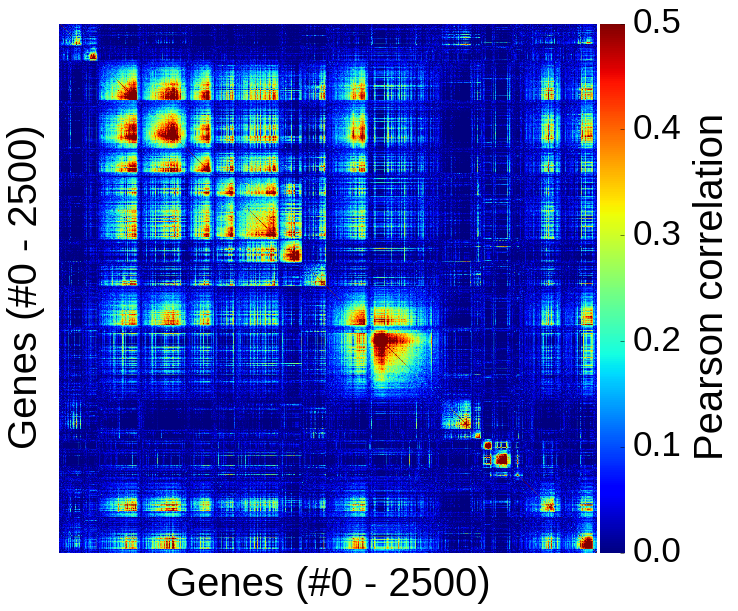

In [112]:
cmap = plt.cm.jet

#generate figure

fig = plt.figure(facecolor = 'w', figsize = (10.625, 10))
gs = plt.GridSpec(nrows = 2, ncols = 3, wspace=0.02, hspace=0.02, width_ratios=[0.5 , 11.25, 0.5], height_ratios=[11.25, 0.5])

#plot heatmap

axHM = plt.subplot(gs[0, 1])

axHM.matshow(seq_g_corr, cmap = cmap, aspect = 'auto', vmin = 0.0, vmax = 0.5, interpolation = None)

axHM.set_xlabel('Genes (#0 - %s)' % len(g_groups_1st.index), family = 'Liberation Sans', fontsize = 40)
axHM.set_ylabel('Genes (#0 - %s)' % len(g_groups_1st.index), family = 'Liberation Sans', fontsize = 40)

axHM.xaxis.set_label_coords(0.5, -0.025)
axHM.yaxis.set_label_coords(-0.025, 0.5)    
    
axHM.set_yticks([])
clean_axis(axHM)

#plot label

axLabel = plt.subplot(gs[0,2])

axLabel.matshow(np.matrix(np.arange(0.5, 0.0, -0.001)).T,
                cmap = cmap, aspect = 'auto', vmin = 0.0, vmax = 0.5)

axLabel.xaxis.set_ticks([])
axLabel.yaxis.set_ticks_position('right')

clean_axis(axLabel)

axLabel.set_yticks(np.linspace(axLabel.get_ylim()[0], axLabel.get_ylim()[1], 6))
axLabel.set_yticklabels(['0.0','0.1','0.2','0.3','0.4','0.5'], family = 'Liberation Sans', fontsize = 35, va = 'center')
axLabel.tick_params(axis='y', which='major', pad=10)

axLabel.set_ylabel('Pearson correlation', family = 'Liberation Sans', fontsize = 40)
axLabel.yaxis.set_label_coords(5.5, 0.5)

figname = 'v1.8_S2_C_Gene_clustering.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# Heatmap of 1st level clustering

In [114]:
#Transfer the expression data to relative values (0 [min] - 1 [max])

seq_sel = log2Transform(seq).ix[g_groups_1st.index, s_groups_1st.index]
seq_sel_= seq_sel.apply(lambda x: x / max(x), axis = 1)


Calculating binary logarithm of x + 1


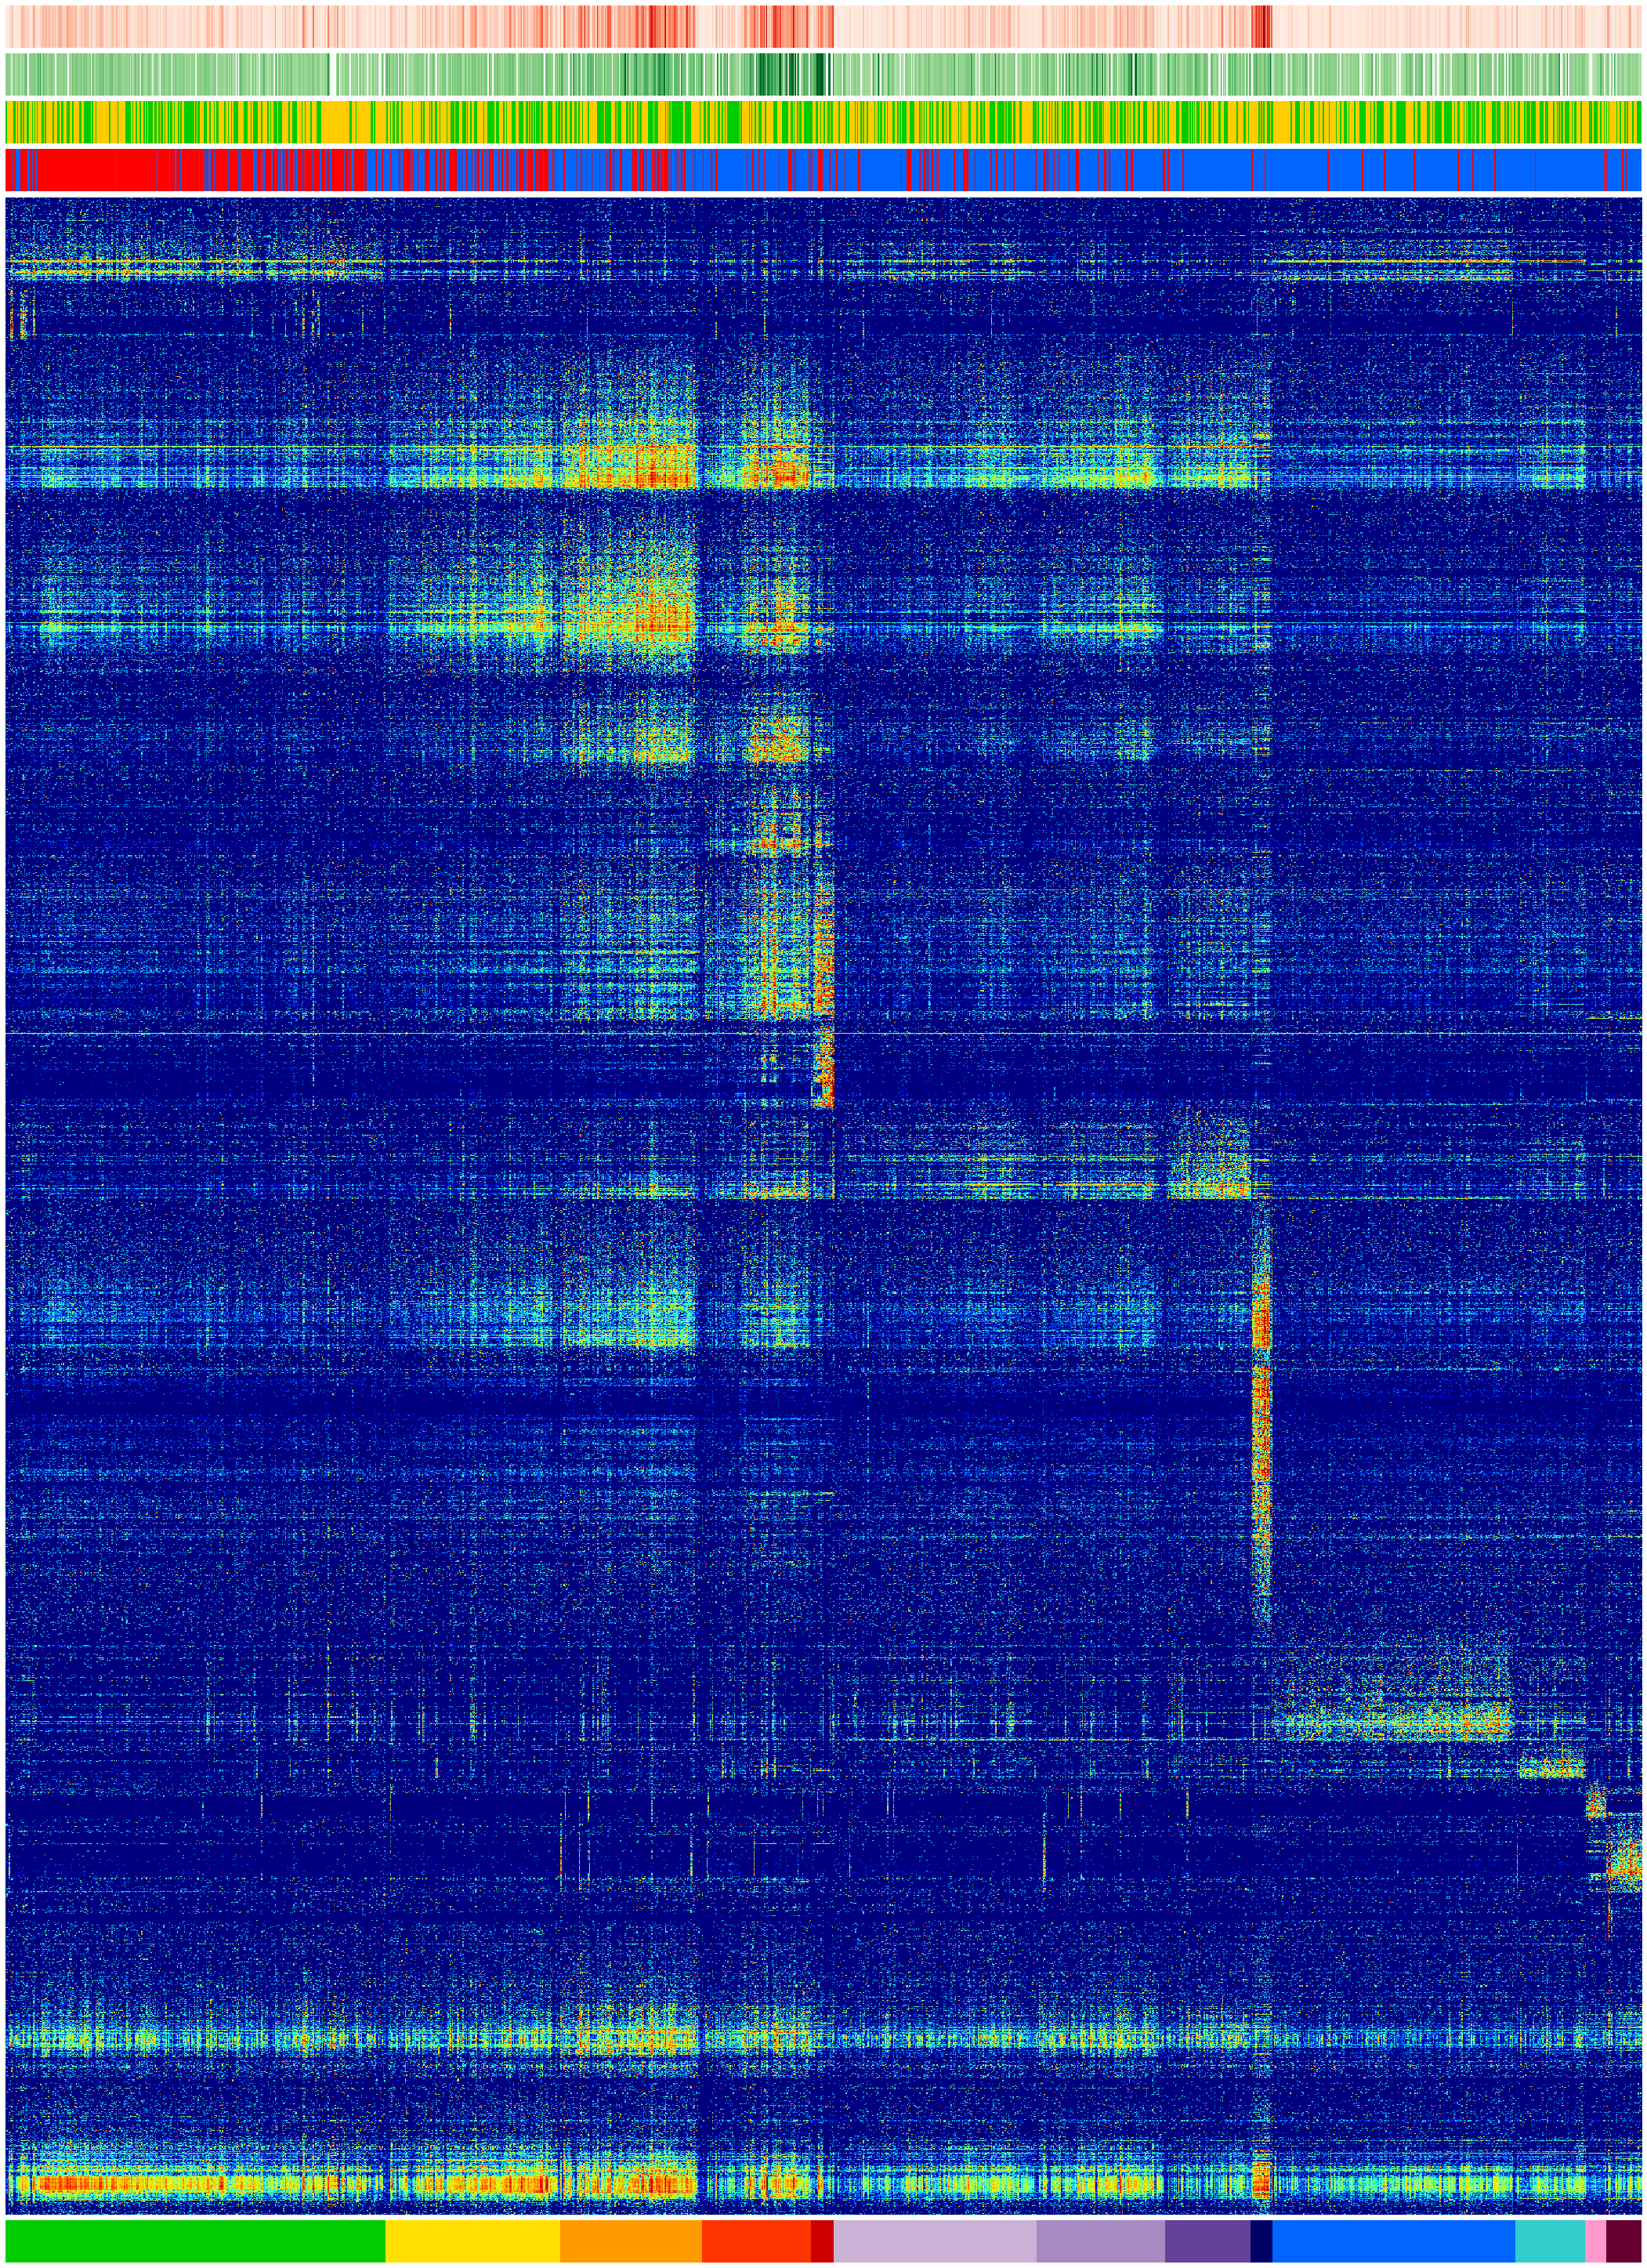

In [116]:
cmap = plt.cm.jet

#create figure

bar_size = 0.75 #size of group and metadata bars
bar_pad = 0.1 #pad size of group and metadata bars
width = 29.0
height = 40.0
#height = ((width - bar_size) / len(s_groups)) * len(g_groups) + 5 * bar_size

plt.figure(figsize=(width, height), facecolor = 'w')

#generate main axes

axHM = plt.axes()
axHM.set_position([0.00, 0.00, 1.0, 1.0])


#plot heatmap

axHM.matshow(seq_sel_,
             cmap = cmap,
             aspect = 'auto',
             interpolation = 'nearest',
             vmin = 0,
             vmax = 1)

remove_ticks(axHM, linewidth = 1)
clean_axis(axHM)

#create axes divider

divider = make_axes_locatable(axHM)

#draw cell/sample groups

axSG = divider.append_axes("bottom", size= bar_size, pad=bar_pad)

axSG.set_xlim(0, len(s_groups_1st))

for pos, gr in enumerate(s_groups_1st):
    axSG.axvspan(pos, pos+1, color=cmap_1st[gr])

remove_ticks(axSG, linewidth = 1)
clean_axis(axSG)

#draw Sca1 metadata

axSCA = divider.append_axes("top", size= bar_size, pad=bar_pad)

axSCA.set_xlim(0, len(s_groups_1st))

for pos, ix in enumerate(s_groups_1st.index):
    axSCA.axvspan(pos, pos+1, color=cmap_Sca1[meta.ix['green_flag', ix]])

remove_ticks(axSCA, linewidth = 1)
clean_axis(axSCA)

#draw hair cycle metadata

axHC = divider.append_axes("top", size= bar_size, pad=bar_pad)

axHC.set_xlim(0, len(s_groups_1st))

for pos, ix in enumerate(s_groups_1st.index):
    axHC.axvspan(pos, pos+1, color=cmap_hair_cycle[meta.ix['hair_cycle_stage', ix]])

remove_ticks(axHC, linewidth = 1)
clean_axis(axHC)

#draw cell size metadata

axSIZE = divider.append_axes("top", size= bar_size, pad=bar_pad)

axSIZE.set_xlim(0, len(s_groups_1st))

cmapSIZE = plt.cm.Greens
SIZE_max = meta.ix['diameter(um)', s_groups_1st.index].astype(float).max()

for pos, ix in enumerate(s_groups_1st.index):
    val = float(meta.ix['diameter(um)', ix])
    axSIZE.axvspan(pos, pos+1, color=cmapSIZE(val/SIZE_max))

remove_ticks(axSIZE, linewidth = 1)
clean_axis(axSIZE)

#draw transcript metadata

axTRANS = divider.append_axes("top", size= bar_size, pad=bar_pad)

axTRANS.set_xlim(0, len(s_groups_1st))

cmapTRANS = plt.cm.Reds
TRANS_max = meta.ix['sum_transcripts', s_groups_1st.index].astype(float).max()

for pos, ix in enumerate(s_groups_1st.index):
    val = float(meta.ix['sum_transcripts', ix])
    axTRANS.axvspan(pos, pos + 1, color = cmapTRANS(val / TRANS_max))

remove_ticks(axTRANS, linewidth = 1)
clean_axis(axTRANS)

figname = 'v1.8_S2_D_Heatmap.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

In [49]:
TRANS_max = meta.ix['sum_transcripts', s_groups_1st.index].astype(float).max()
cmapTRANS = plt.cm.Reds

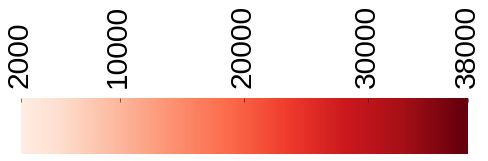

In [126]:
#generate figure

plt.figure(facecolor = 'w', figsize = (8, 1))

axLabel = plt.subplot()
axLabel.set_xlim(2000, 38000)

for pos in np.arange(2000, 38000, 1):
    axLabel.axvspan(pos, pos+1, color = cmapTRANS(pos / TRANS_max))

axLabel.yaxis.set_ticks([])
axLabel.xaxis.set_ticks_position('top')

clean_axis(axLabel)

axLabel.set_xticks([2000, 10000, 20000, 30000, 38000])
axLabel.set_xticklabels([2000, 10000, 20000, 30000, 38000], family = 'Liberation Sans', 
                        fontsize = 30, ha = 'center', rotation = 'vertical')
axLabel.tick_params(axis='x', which='major', pad=10)


figname = 'v1.8_S2_D_Legend_Transcripts.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

In [51]:
SIZE_max = meta.ix['diameter(um)', s_groups_1st.index].astype(float).max()
cmapSIZE = plt.cm.Greens

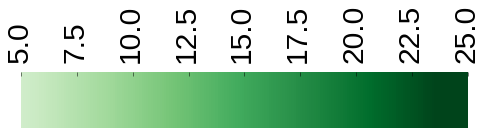

In [127]:
#generate figure

fig = plt.figure(facecolor = 'w', figsize = (8, 1))

axLabel = plt.subplot()
axLabel.set_xlim(5, 25)

for pos in np.arange(5, 25, 0.1):
    axLabel.axvspan(pos, pos+1, color = cmapSIZE(pos / SIZE_max))

axLabel.yaxis.set_ticks([])
axLabel.xaxis.set_ticks_position('top')

clean_axis(axLabel)

axLabel.set_xticks([5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25])
axLabel.set_xticklabels([5.0, 7.5, 10.0, 12.5, 15.0, 17.5, 20.0, 22.5, 25.0], family = 'Liberation Sans', 
                        fontsize = 30, ha = 'center', rotation = 'vertical')
axLabel.tick_params(axis='x', which='major', pad=10)

figname = 'v1.8_S2_D_Legend_Diameter.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

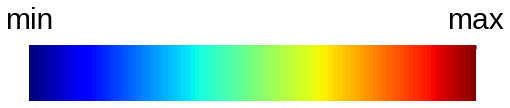

In [130]:
#generate figure

fig = plt.figure(facecolor = 'w', figsize = (8, 1))

axLabel = plt.subplot()
axLabel.set_xlim(0, 1)

for pos in np.arange(0, 1, 0.01):
    axLabel.axvspan(pos, pos+1, color = plt.cm.jet(pos))

axLabel.yaxis.set_ticks([])
axLabel.xaxis.set_ticks_position('top')

clean_axis(axLabel)

axLabel.set_xticks([0,1])
axLabel.set_xticklabels(['min','max'], family = 'Liberation Sans', 
                        fontsize = 30, ha = 'center', rotation = 'horizontal')
axLabel.tick_params(axis='x', which='major', pad=10)

figname = 'v1.8_S2_D_Legend_Expression.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

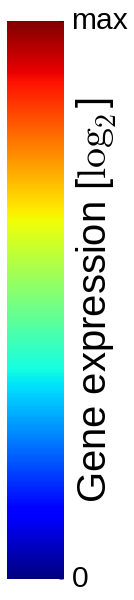

In [151]:
#initialize figure

height = 10
width = 1

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#draw

axLabel = plt.subplot()

axLabel.matshow(np.matrix(np.arange(1.0, 0.0, -0.001)).T,
                cmap = plt.cm.jet, aspect = 'auto', vmin = 0.0, vmax = 1.0)

axLabel.xaxis.set_ticks([])
axLabel.yaxis.set_ticks_position('right')

clean_axis(axLabel)

axLabel.set_yticks([axLabel.get_ylim()[0], axLabel.get_ylim()[1]])
axLabel.set_yticklabels([0,'max'], family = 'Liberation Sans', fontsize = 30, va = 'center')
axLabel.tick_params(axis='y', which='major', pad=10)

axLabel.set_ylabel('Gene expression [$\log_2$]', family = 'Liberation Sans', fontsize = 40)
axLabel.yaxis.set_label_coords(2, 0.5)

figname = 'v1.8_S3_B_Legend_Gene_expression.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# Validation of cluster robustness - AP

In [54]:
robustness_1st = loadData_v1(path_output, exp_id, 'robustness_1st', 'DataFrame')
robustness_1st_null = loadData_v1(path_output, exp_id, 'robustness_1st_null', 'DataFrame')

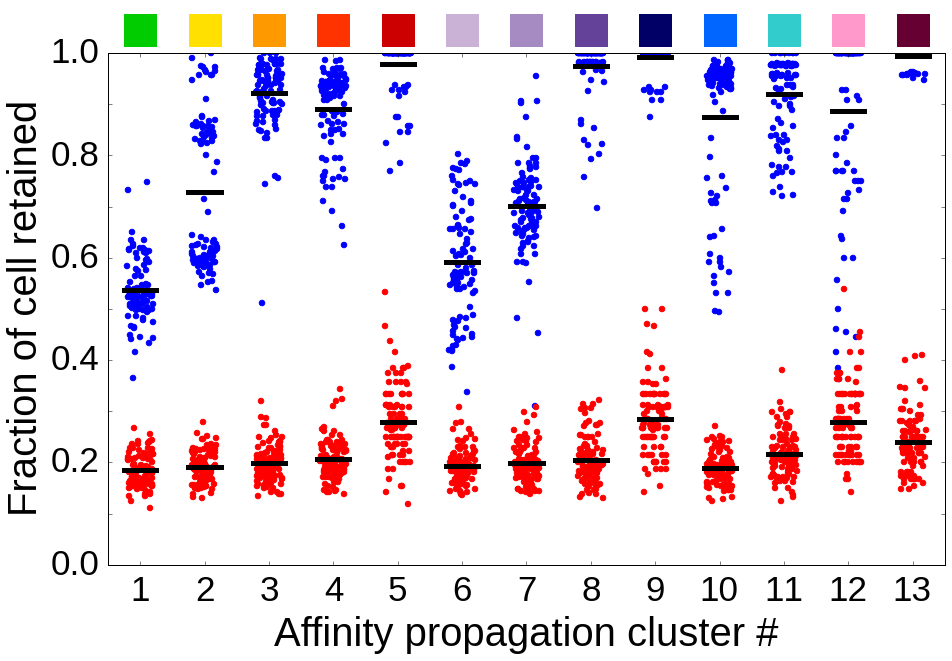

In [120]:
#generate figure

fig = plt.figure(facecolor = 'w', figsize = (15, 10))
gs = plt.GridSpec(nrows = 2, ncols = 1, wspace=0.0, hspace=0.0, height_ratios=[1.0, 11.0])

#generate plot

ax = plt.subplot(gs[1])

#generate xaxis

ax.set_xlim(- 0.5, len(set(s_groups_1st)) - 0.5)
ax.set_xticks(range(len(set(s_groups_1st))))
ax.set_xticklabels(np.arange(0, len(set(s_groups_1st))) + 1, family = 'Liberation Sans', fontsize = 35)
ax.set_xlabel('Affinity propagation cluster #', family = 'Liberation Sans', fontsize = 40)
ax.xaxis.set_label_coords(0.5, -0.1)
ax.tick_params(axis='x', which='major', pad=10)

#generate yaxis

ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_yticklabels([0.0,'',0.2,'',0.4,'',0.6,'',0.8,'',1.0], family = 'Liberation Sans', fontsize = 35)
ax.set_ylabel('Fraction of cell retained', family = 'Liberation Sans', fontsize = 40)
ax.yaxis.set_label_coords(-0.075, 0.5)
ax.tick_params(axis='y', which='major', pad=10)

#plot data

for ix, gr in enumerate(return_unique(s_groups_1st)):
    
    ax.scatter([ix - (np.random.random() * 0.4 - 0.2) for pos in robustness_1st[str(gr)]],
               robustness_1st[str(gr)],
               s = 30, 
               color = 'blue')
    
    ax.plot([ix - 0.25, ix + 0.25],
            [np.mean(robustness_1st[str(gr)])] * 2,
            linewidth = 5,
            color = 'black')
       
    ax.scatter([ix - (np.random.random() * 0.4 - 0.2) for pos in robustness_1st[str(gr)]],
               robustness_1st_null[str(gr)],
               s = 30, 
               color = 'red')
        
    ax.plot([ix - 0.25, ix + 0.25],
            [np.mean(robustness_1st_null[str(gr)])] * 2,
            linewidth = 5,
            color = 'black')
    
#plot color symbols

ax_Sym = plt.subplot(gs[0])

ax_Sym.set_xlim(- 0.5, len(set(s_groups_1st)) - 0.5)
ax_Sym.set_ylim(-0.5, 0.5)

for ix, gr in enumerate(return_unique(s_groups_1st)):
    
    ax_Sym.scatter(ix,
               0.0,
               marker = 's',
               s = 1000,
               color = cmap_1st[gr])
    
clean_axis(ax_Sym)

figname = 'v1.8_S2_E_Robustness.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# Affinity propagation vs. backSPIN

In [57]:
cells_BS = pd.read_csv('%s/cells_ordercluster_backspin_lev5_5000_oct28_2014.txt' % path_output,
                        sep='\t', index_col = None, header = None, squeeze = True)

cells_BS1 = pd.Series(cells_BS.ix[1].values, index = cells_BS.ix[0])
cells_BS2 = pd.Series(cells_BS.ix[2].values, index = cells_BS.ix[0])

In [60]:
#generate matrix

AP_BS_1 = pd.DataFrame(columns = set(s_groups_1st), index = set(cells_BS.ix[1])).fillna(0)

for gr in set(s_groups_1st):
    
    ix_sel = s_groups_1st[s_groups_1st == gr].index
    
    counter_tmp = Counter(cells_BS1[ix_sel])
    
    for key in [key for key in counter_tmp.keys() if type(key) == str]:
        
        AP_BS_1.ix[key, gr] = float(counter_tmp[key]) / len(ix_sel)

In [67]:
#order groups

AP_BS_1 = AP_BS_1.ix[['4','1','2','8','3','5','6','7'], return_unique(s_groups_1st)]

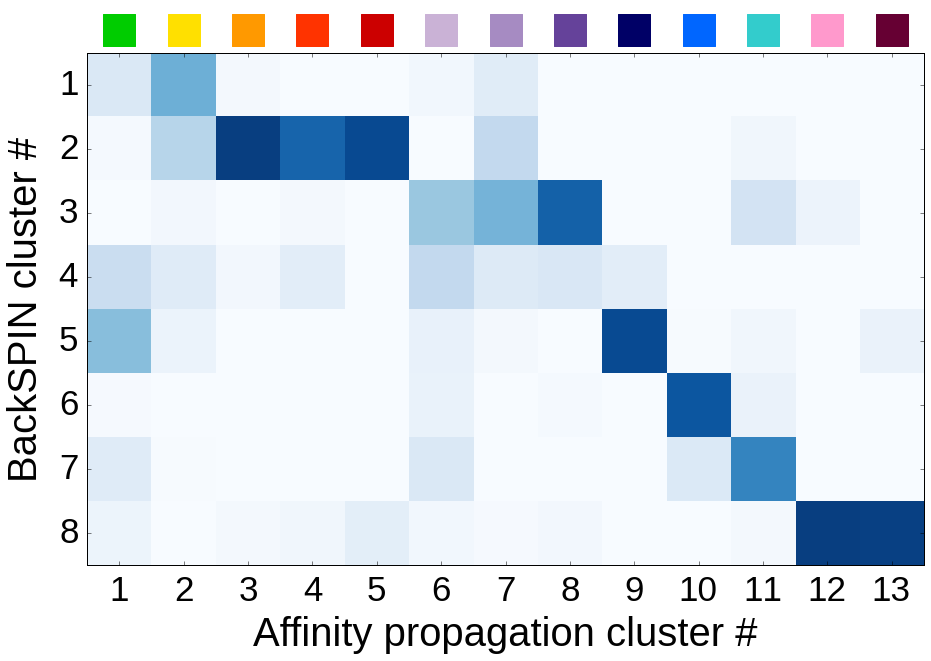

In [122]:
data = AP_BS_1

#generate figure

fig = plt.figure(facecolor = 'w', figsize = (15, 10))
gs = plt.GridSpec(nrows = 2, ncols = 1, wspace=0.0, hspace=0.0, height_ratios=[1.0, 11.0])

#generate plot

ax = plt.subplot(gs[1])

#generate xaxis

ax.set_xlim(-0.5, len(data.columns) - 0.5)
ax.set_xticks(np.arange(0, len(data.columns)))
ax.set_xticklabels(np.arange(0, len(data.columns)) + 1, family = 'Liberation Sans', fontsize = 35)
ax.set_xlabel('Affinity propagation cluster #', family = 'Liberation Sans', fontsize = 40)
ax.xaxis.set_label_coords(0.5, -0.1)
ax.tick_params(axis='x', which='major', pad=10)

#generate yaxis

ax.set_ylim(len(data.index) -0.5, -0.5)
ax.set_yticks(np.arange(0, len(data.index)))
ax.set_yticklabels(np.arange(0, len(data.index)) + 1, family = 'Liberation Sans', fontsize = 35)
ax.set_ylabel('BackSPIN cluster #', family = 'Liberation Sans', fontsize = 40)
ax.yaxis.set_label_coords(-0.05, 0.5)
ax.tick_params(axis='y', which='major', pad=10)


#plot data

ax.imshow(AP_BS_1,
           cmap = plt.cm.Blues,
           aspect = 'auto',
           interpolation = 'nearest',
           vmin = 0, vmax = 1)
    
#plot color symbols

ax_Sym = plt.subplot(gs[0])

ax_Sym.set_xlim(- 0.5, len(set(s_groups_1st)) - 0.5)
ax_Sym.set_ylim(-0.5, 0.5)

for ix, gr in enumerate(return_unique(s_groups_1st)):
    
    ax_Sym.scatter(ix,
               0.0,
               marker = 's',
               s = 1000,
               color = cmap_1st[gr])
    
clean_axis(ax_Sym)

figname = 'v1.8_S2_F_AP_vs_BackSPIN.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

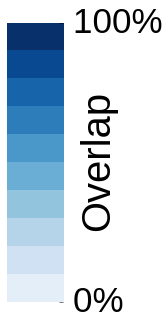

In [125]:
#initialize figure

height = 5
width = 1

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#draw

axLabel = plt.subplot()

axLabel.matshow(np.matrix(np.arange(100, 0, -10)).T,
                cmap = plt.cm.Blues, aspect = 'auto', vmin = 0.0, vmax = 100)

axLabel.xaxis.set_ticks([])
axLabel.yaxis.set_ticks_position('right')

clean_axis(axLabel)

axLabel.set_yticks([axLabel.get_ylim()[0], axLabel.get_ylim()[1]])
axLabel.set_yticklabels(['0% ','100% '], family = 'Liberation Sans', fontsize = 35, va = 'center')
plt.rcParams['ytick.major.pad'] = 10

axLabel.set_ylabel('Overlap', family = 'Liberation Sans', fontsize = 40)
axLabel.yaxis.set_label_coords(2, 0.5)

figname = 'v1.8_S2_F_Legend.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# t-SNE - cell groups

In [70]:
tsne_1st = loadData_v1(path_output, exp_id, 'tsne_1st', 'DataFrame')

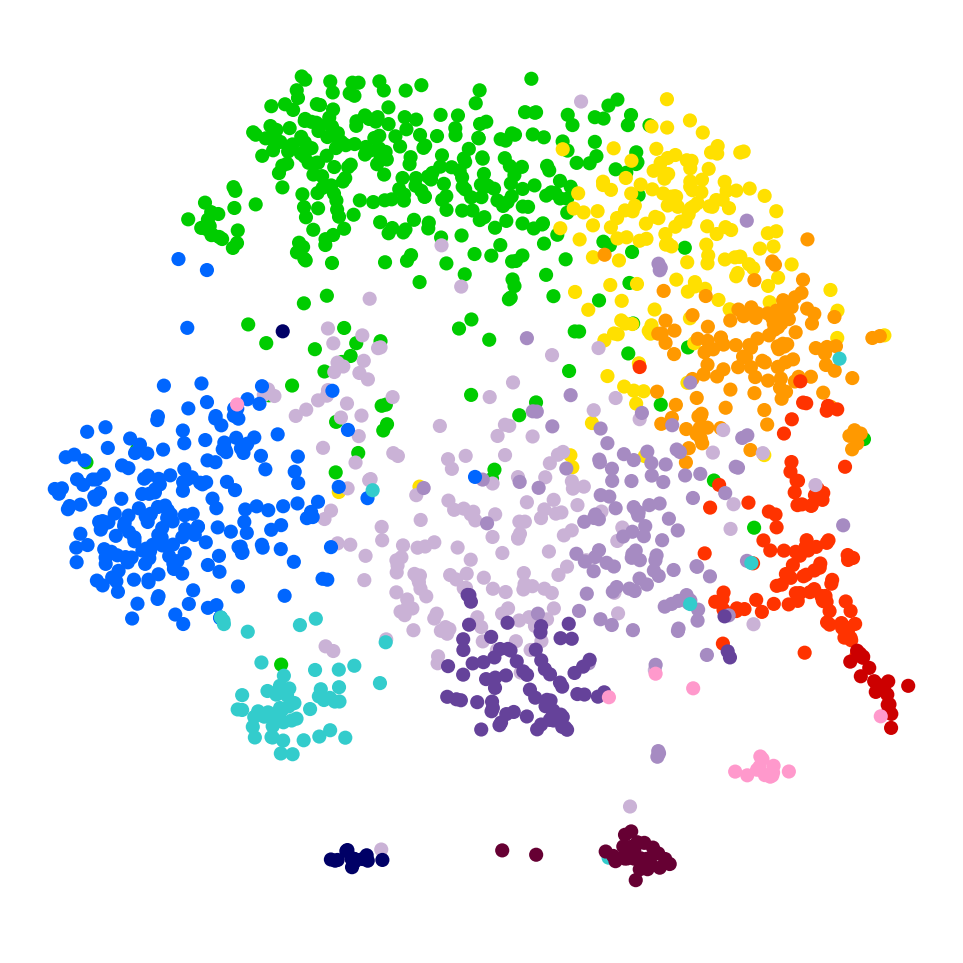

In [131]:
tsne = tsne_1st

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

clist_tsne = [cmap_1st[s_groups_1st[ix]] for ix in tsne.index]

ax1.scatter(tsne['x'],
            tsne['y'], 
            s = 200,
            linewidth = 0.0,
            c = clist_tsne,
            cmap = plt.cm.jet,
            edgecolor=clist_tsne)

clean_axis(ax1)

figname = 'v1.8_1_C_t-SNE_1st.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# Cell group legend

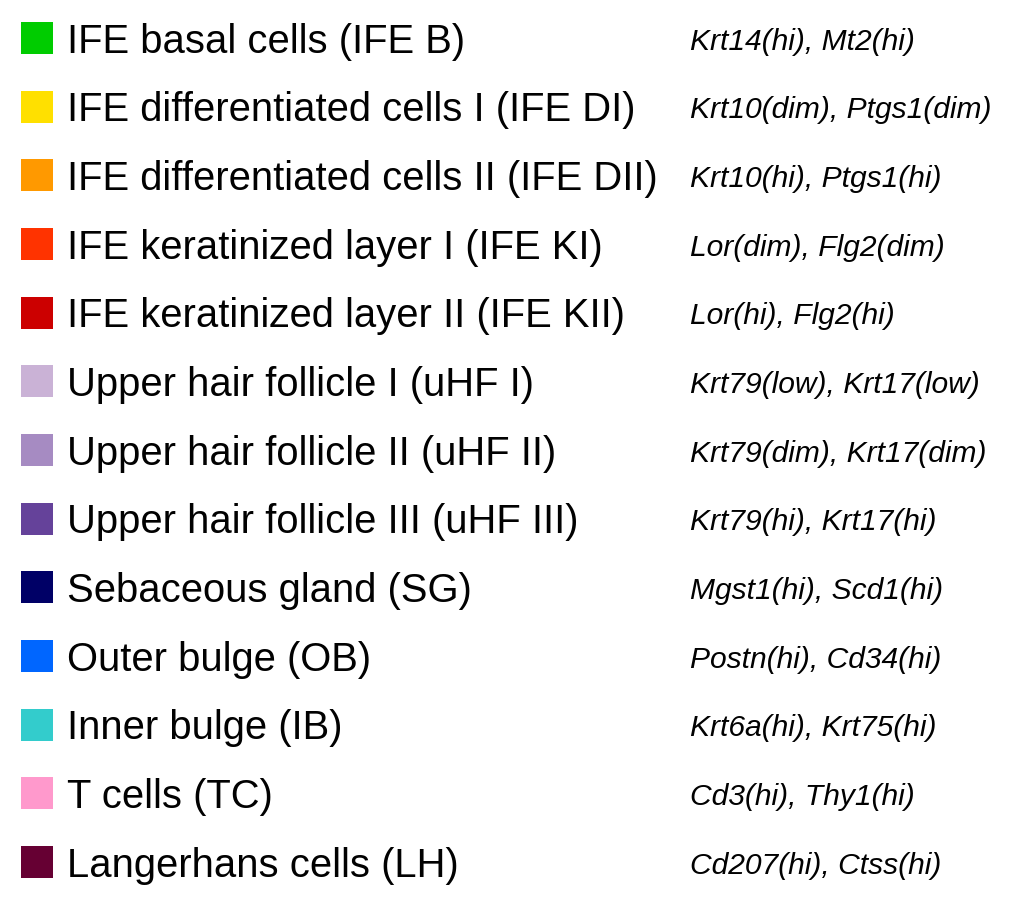

In [124]:
#initialize figure

width = 18
height = 16

fig = plt.figure(facecolor = 'w', figsize = (width, height))

gs = GridSpec(1,1)

ax0 = fig.add_subplot(gs[0])
ax0.set_ylim(12.5, -0.5)
ax0.set_xlim(0, 1)

group_list = return_unique(s_groups_1st)

x = 0.03

for pos in range(len(group_list)):      
    
    ax0.scatter(x, pos-0.05, c = cmap_1st[group_list[pos]], cmap = plt.cm.jet, marker = 's', vmin = 0, vmax = 1.0, s = 1000, 
                linewidth = 0.0)
        
    ax0.text(x + 0.03, pos, nmap_1st[group_list[pos]], family = 'Liberation Sans', fontsize = 40, va = 'center', ha = 'left')
    
    ax0.text(x + 0.65, pos, gmap_1st[group_list[pos]], fontsize = 30, family = 'Liberation Sans', va = 'center', ha = 'left',
             fontstyle = 'italic')
    
remove_ticks(ax0)

#ax0.axvline(ax0.get_xlim()[0], color = 'black', linewidth = 2)
#ax0.axvline(ax0.get_xlim()[1], color = 'black', linewidth = 2)
#ax0.axhline(ax0.get_ylim()[0], color = 'black', linewidth = 2)
#ax0.axhline(ax0.get_ylim()[1], color = 'black', linewidth = 2)

clean_axis(ax0)

figname = 'v1.8_S2_Legend_cell_groups.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# Cell group distance matrix

In [73]:
seq = loadData_v1(path_input, exp_id, 'seq', 'DataFrame')

In [80]:
#use all genes with mean expression > 0.05

seq_sel_ = dropNull(seq[s_groups_1st.index], path_input, cutoff_mean=0.10)
seq_sel_ = log2Transform(seq_sel_)


Dropping spikes from dataset

Dropping repeats from dataset

Dropping unexpressed genes from dataset

Calculating binary logarithm of x + 1


In [81]:
#calculate group averages

group_avg = pd.DataFrame(index = seq_sel_.index, columns = set(s_groups_1st))

for group in set(s_groups_1st):
    group_avg_tmp = seq_sel_[s_groups_1st[s_groups_1st == group].index].mean(axis=1)
    group_avg[group] = group_avg_tmp

In [82]:
#create group distance matrix (euclidean distance for Ward linkage)

group_avg_dist = squareform(pdist(group_avg.T, 'euclidean'))

In [83]:
#create single-linkage clustering

seq_cluster = ward(group_avg_dist)

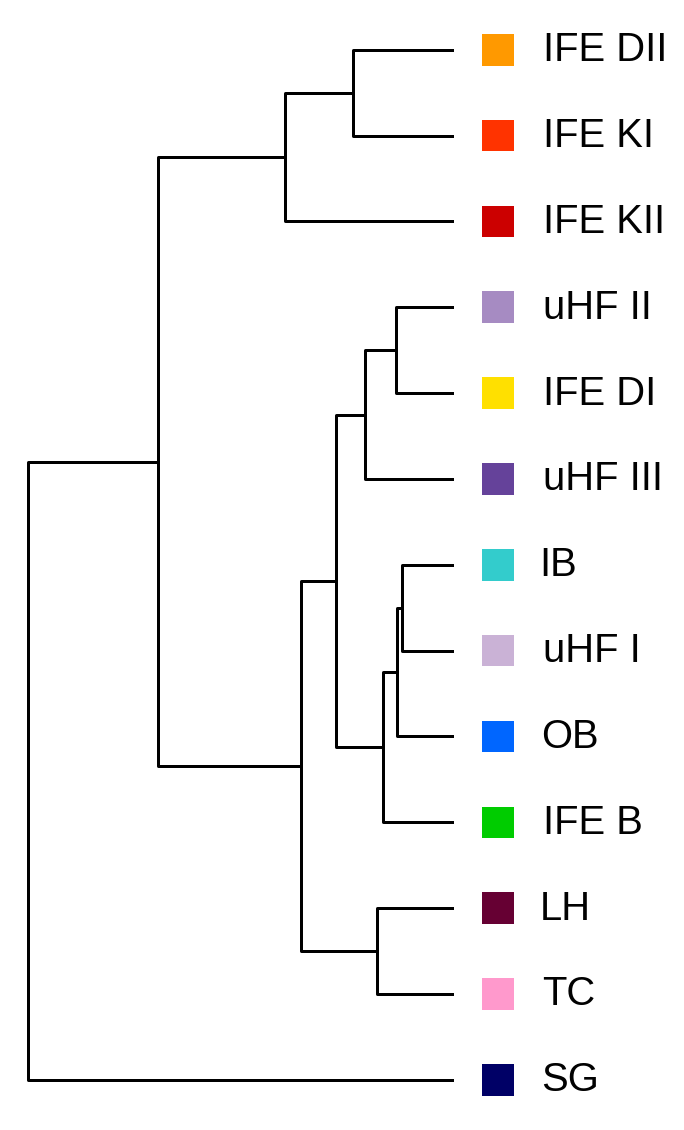

In [138]:
#create figure and GridSpec

height = 20
width = 12

fig = plt.figure(facecolor = 'w', figsize = (width, height))
heatmapGS = GridSpec(1,2,wspace=0.0,hspace=0.0,width_ratios=[8,4])

#create dendogramm

ax_dend = fig.add_subplot(heatmapGS[0])
den = sch.dendrogram(seq_cluster,color_threshold=np.inf, orientation='right')
leaves = den['leaves']

lines = ax_dend.get_children()[2]
lines.set_color('black')
lines.set_linewidth(3)
    
clean_axis(ax_dend)

#create labels

ax_label = fig.add_subplot(heatmapGS[1])

ax_label.set_ylim(bottom = 0, top = len(leaves))
ax_label.set_xlim(left = 0, right = 10)

ax_label.scatter(x = [2 for element in leaves],
                 y = [val + 0.5 for val in range(len(leaves))],
                 c = [cmap_1st[group_avg.columns[val]] for val in leaves],
                 vmin = 0, 
                 vmax = 1.0,
                 linewidth = 0,
                 s = 1000,
                 marker = 's',
                 edgecolor=[cmap_1st[group_avg.columns[val]] for val in leaves])

clean_axis(ax_label)

for pos in range(len(leaves)):
    ax_label.text(x = 4, y = pos + 0.5, s = nmap_1st_short[group_avg.columns[leaves[pos]]],
                  family = 'Liberation Sans', size = 40, va = 'center')

    
figname = 'v1.8_1_E_1st_Wards_Linkage.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# t-SNE marker genes

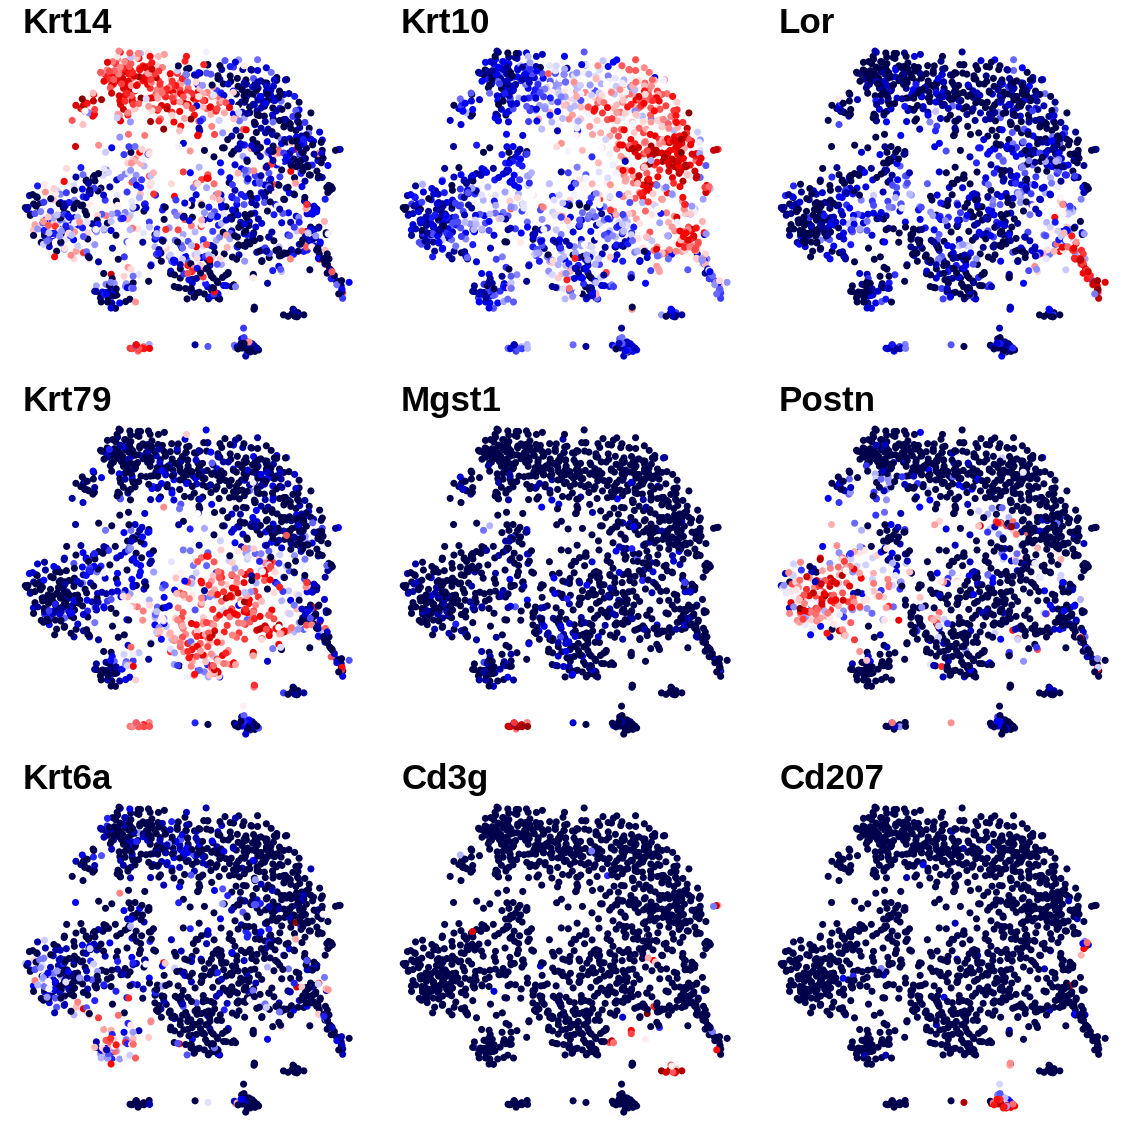

In [132]:
cmap = plt.cm.seismic

dataset = seq_sel.apply(lambda x: x / np.max(x), axis = 1)
tsne = tsne_1st

#initialize figure

height = 20
width = 20

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2

#draw Krt14

gene = 'Krt14'

ax0 = plt.subplot2grid((3,3), (0,0))

ax0.set_xlim(xlim[0], xlim[1])
ax0.set_ylim(ylim[0], ylim[1])

remove_ticks(ax0)

ax0.scatter(tsne['x'],
            tsne['y'], 
            s = 50,
            linewidth = 0.0,
            c = dataset.ix[gene, tsne.index],
            edgecolor = [cmap(val) for val in dataset.ix[gene, tsne.index]],
            cmap = cmap)

ax0.text(ax0.get_xlim()[0] + text_pad,
         ax0.get_ylim()[1] + text_pad,
         gene,
         family = 'Liberation Sans', fontsize = 35, va = 'top', weight = 'bold')

clean_axis(ax0)

#draw Krt79

gene = 'Krt79'

ax1 = plt.subplot2grid((3,3), (1,0))

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

ax1.scatter(tsne['x'],
            tsne['y'], 
            s = 50,
            linewidth = 0.0,
            c = dataset.ix[gene, tsne.index],
            edgecolor = [cmap(val) for val in dataset.ix[gene, tsne.index]],
            cmap = cmap)

ax1.text(ax1.get_xlim()[0] + text_pad,
         ax1.get_ylim()[1] + text_pad,
         gene,
         family = 'Liberation Sans', fontsize = 35, va = 'top', weight = 'bold')

clean_axis(ax1)

#draw Krt6a

gene  = 'Krt6a'

ax2 = plt.subplot2grid((3,3), (2,0))

ax2.set_xlim(xlim[0], xlim[1])
ax2.set_ylim(ylim[0], ylim[1])

remove_ticks(ax2)

ax2.scatter(tsne['x'],
            tsne['y'], 
            s = 50,
            linewidth = 0.0,
            c = dataset.ix[gene, tsne.index],
            edgecolor = [cmap(val) for val in dataset.ix[gene, tsne.index]],
            cmap = cmap)

ax2.text(ax2.get_xlim()[0] + text_pad,
         ax2.get_ylim()[1] + text_pad,
         gene,
         family = 'Liberation Sans', fontsize = 35, va = 'top', weight = 'bold')

clean_axis(ax2)

#draw Krt10

gene = 'Krt10'

ax3 = plt.subplot2grid((3,3), (0,1))

ax3.set_xlim(xlim[0], xlim[1])
ax3.set_ylim(ylim[0], ylim[1])

remove_ticks(ax3)

ax3.scatter(tsne['x'],
            tsne['y'], 
            s = 50,
            linewidth = 0.0,
            c = dataset.ix[gene, tsne.index],
            edgecolor = [cmap(val) for val in dataset.ix[gene, tsne.index]],
            cmap = cmap)

ax3.text(ax3.get_xlim()[0] + text_pad,
         ax3.get_ylim()[1] + text_pad,
         gene,
         family = 'Liberation Sans', fontsize = 35, va = 'top', weight = 'bold')

clean_axis(ax3)

#draw Mgst1

gene = 'Mgst1'

ax4 = plt.subplot2grid((3,3), (1,1))

ax4.set_xlim(xlim[0], xlim[1])
ax4.set_ylim(ylim[0], ylim[1])

remove_ticks(ax4)

ax4.scatter(tsne['x'],
            tsne['y'], 
            s = 50,
            linewidth = 0.0,
            c = dataset.ix[gene, tsne.index],
            edgecolor = [cmap(val) for val in dataset.ix[gene, tsne.index]],
            cmap = cmap)

ax4.text(ax4.get_xlim()[0] + text_pad,
         ax4.get_ylim()[1] + text_pad,
         gene,
         family = 'Liberation Sans', fontsize = 35, va = 'top', weight = 'bold')

clean_axis(ax4)

#draw Cd3g

gene = 'Cd3g'

ax5 = plt.subplot2grid((3,3), (2,1))

ax5.set_xlim(xlim[0], xlim[1])
ax5.set_ylim(ylim[0], ylim[1])

remove_ticks(ax5)

ax5.scatter(tsne['x'],
            tsne['y'], 
            s = 50,
            linewidth = 0.0,
            c = dataset.ix[gene, tsne.index],
            edgecolor = [cmap(val) for val in dataset.ix[gene, tsne.index]],
            cmap = cmap)

ax5.text(ax5.get_xlim()[0] + text_pad,
         ax5.get_ylim()[1] + text_pad,
         gene,
         family = 'Liberation Sans', fontsize = 35, va = 'top', weight = 'bold')

clean_axis(ax5)

#draw Lor

gene = 'Lor'

ax6 = plt.subplot2grid((3,3), (0,2))

ax6.set_xlim(xlim[0], xlim[1])
ax6.set_ylim(ylim[0], ylim[1])

remove_ticks(ax6)

ax6.scatter(tsne['x'],
            tsne['y'], 
            s = 50,
            linewidth = 0.0,
            c = dataset.ix[gene, tsne.index],
            edgecolor = [cmap(val) for val in dataset.ix[gene, tsne.index]],
            cmap = cmap)

ax6.text(ax6.get_xlim()[0] + text_pad,
         ax6.get_ylim()[1] + text_pad,
         gene,
         family = 'Liberation Sans', fontsize = 35, va = 'top', weight = 'bold')

clean_axis(ax6)

#draw Postn

gene = 'Postn'

ax7 = plt.subplot2grid((3,3), (1,2))

ax7.set_xlim(xlim[0], xlim[1])
ax7.set_ylim(ylim[0], ylim[1])

remove_ticks(ax7)

ax7.scatter(tsne['x'],
            tsne['y'], 
            s = 50,
            linewidth = 0.0,
            c = dataset.ix[gene, tsne.index],
            edgecolor = [cmap(val) for val in dataset.ix[gene, tsne.index]],
            cmap = cmap)

ax7.text(ax7.get_xlim()[0] + text_pad,
         ax7.get_ylim()[1] + text_pad,
         gene,
         family = 'Liberation Sans', fontsize = 35, va = 'top', weight = 'bold')

clean_axis(ax7)

plt.subplots_adjust(wspace = 0.05, hspace = 0.05)

#draw Cd207

gene = 'Cd207'

ax8 = plt.subplot2grid((3,3), (2,2))

ax8.set_xlim(xlim[0], xlim[1])
ax8.set_ylim(ylim[0], ylim[1])

remove_ticks(ax8)

ax8.scatter(tsne['x'],
            tsne['y'], 
            s = 50,
            linewidth = 0.0,
            c = dataset.ix[gene, tsne.index],
            edgecolor = [cmap(val) for val in dataset.ix[gene, tsne.index]],
            cmap = cmap)

ax8.text(ax8.get_xlim()[0] + text_pad,
         ax8.get_ylim()[1] + text_pad,
         gene,
         family = 'Liberation Sans', fontsize = 35, va = 'top', weight = 'bold')

clean_axis(ax8)

plt.subplots_adjust(wspace = 0.05, hspace = 0.05)


figname = 'v1.8_1_D_t-SNE_1st_markers.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

"\nfigname = 'v1.7_1_D1_Legend_expression.pdf'\nplt.savefig('%s/%s' % (path_figures, figname), \n            format = 'pdf', \n            transparent = True, \n            bbox_inches = 'tight', \n            pad_inches = 0, \n            rasterized = True)\n"

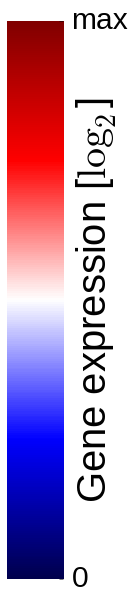

In [142]:
#initialize figure

height = 10
width = 1

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#draw

axLabel = plt.subplot()

axLabel.matshow(np.matrix(np.arange(1.0, 0.0, -0.001)).T,
                cmap = plt.cm.seismic, aspect = 'auto', vmin = 0.0, vmax = 1.0)

axLabel.xaxis.set_ticks([])
axLabel.yaxis.set_ticks_position('right')

clean_axis(axLabel)

axLabel.set_yticks([axLabel.get_ylim()[0], axLabel.get_ylim()[1]])
axLabel.set_yticklabels(['0','max'], family = 'Liberation Sans', fontsize = 30, va = 'center')
axLabel.tick_params(axis='y', which='major', pad=10)

axLabel.set_ylabel('Gene expression [$\log_2$]', family = 'Liberation Sans', fontsize = 40)
axLabel.yaxis.set_label_coords(2, 0.5)
"""
figname = 'v1.7_1_D1_Legend_expression.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)
"""

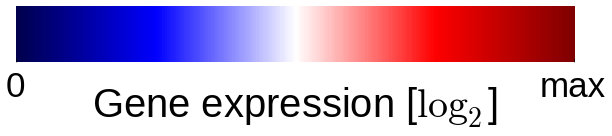

In [150]:
#initialize figure

height = 1
width = 10

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#draw

axLabel = plt.subplot()

axLabel.matshow(np.matrix(np.arange(0.0, 1.0, 0.001)),
                cmap = plt.cm.seismic, aspect = 'auto', vmin = 0.0, vmax = 1.0)

axLabel.yaxis.set_ticks([])
axLabel.xaxis.set_ticks_position('bottom')

clean_axis(axLabel)

axLabel.set_xticks([axLabel.get_xlim()[0], axLabel.get_xlim()[1]])
axLabel.set_xticklabels(['0','max'], family = 'Liberation Sans', fontsize = 35, va = 'center')
axLabel.tick_params(axis='x', which='major', pad=25)

axLabel.set_xlabel('Gene expression [$\log_2$]', family = 'Liberation Sans', fontsize = 40)
axLabel.xaxis.set_label_coords(0.5, -0.4)

figname = 'v1.8_1_D_Legend_expression.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# Negative binominal regression vs. Baseline

In [20]:
NBR_1st_traces = loadData_from_pickle_v1(path_output, exp_id, 'NBR_1st_traces')
NBR_1st_summary = loadData_from_pickle_v1(path_output, exp_id,'NBR_1st_summary')
NBR_1st_bin_bl = loadData_from_pickle_v1(path_output,exp_id,'NBR_1st_bin_bl')
NBR_1st_size_bl = loadData_from_pickle_v1(path_output,exp_id,'NBR_1st_size_bl')
NBR_1st_bin_gr = loadData_from_pickle_v1(path_output,exp_id,'NBR_1st_bin_gr')
NBR_1st_size_gr = loadData_from_pickle_v1(path_output,exp_id,'NBR_1st_size_gr')

In [21]:
genes_baseline = neg_binom_extract_genes(NBR_1st_size_bl, score = 'percentile - 25', number = 10)

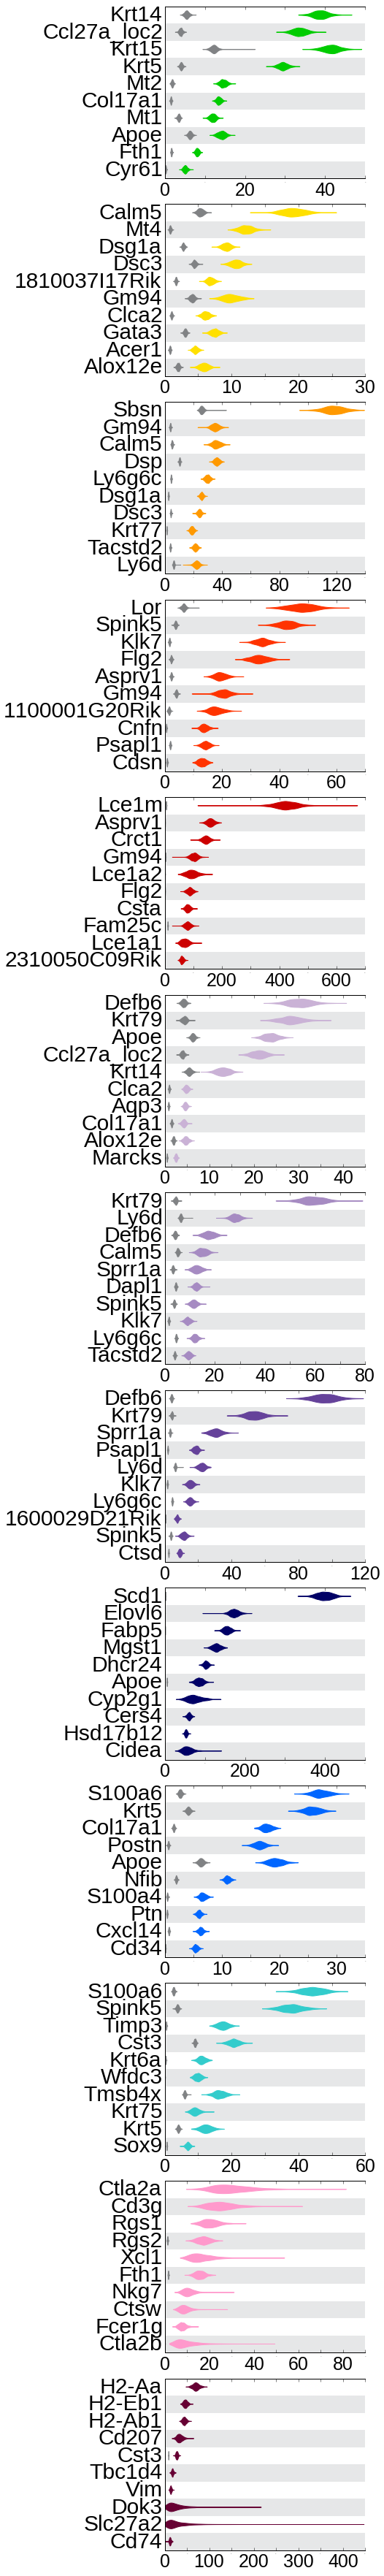

In [100]:
#define input variables

gr_order = return_unique(s_groups_1st)
genes = genes_baseline
L = len(genes.index)
traces = NBR_1st_traces
cmap = cmap_1st

#initialize figure

height = 4.8 * len(gr_order)
width = 8

plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(len(gr_order), 2, hspace = 0.15, wspace = 0.0, width_ratios = [5,8])

#iterate through groups

for pos, gr in enumerate(gr_order):
    
    genes_tmp = [gene for gene in genes[str(gr)].values if gene != None]
    
    #create gene name axis 
    
    ax0 = plt.subplot(gs[pos,0])
    ax0.set_ylim(L - 0.5, -0.5)
    clean_axis(ax0)
    
    #create violin plot axis
    
    ax1 = plt.subplot(gs[pos,1])
    
    ax1.spines['right'].set_color('none')

    ax1.set_ylim(L - 0.5, -0.5)
    ax1.yaxis.set_ticks_position('left')
    ax1.yaxis.set_ticks([])
    
    #iterate over genes
    
    for ix, g in enumerate(genes_tmp):
        ax0.text(0.975, ix, g, family = 'Liberation Sans', fontsize = 30, ha = 'right', va = 'center')
        
        #print background
        
        if ix % 2 == 0:
            ax1.axhspan(ix - 0.5, ix + 0.5, color = '#FFFFFF', zorder = 0)
            
        if ix % 2 == 1:
            ax1.axhspan(ix - 0.5, ix + 0.5, color = '#E6E7E8', zorder = 0)
            
        #print group traces
        
        violin = ax1.violinplot([x - 1 for x in traces.ix[g, str(gr)]],
                       positions = [ix],
                       vert=False,
                       showextrema=False)
        
        for v in violin['bodies']:
            v.set_edgecolor(cmap[gr])
            v.set_facecolor(cmap[gr])
            v.set_linewidth(1.0)
            v.set_alpha(1.0)
            
        #print baseline traces
        
        violin = ax1.violinplot([x - 1 for x in traces.ix[g, 'Baseline']],
                       positions = [ix],
                       vert=False,
                       showextrema=False)
        
        for v in violin['bodies']:
            v.set_edgecolor('#808284')
            v.set_facecolor('#808284')
            v.set_linewidth(1.0)
            v.set_alpha(1.0)

    for ix, t in enumerate(ax1.xaxis.get_ticklabels()):
        if ix % 2 == 0:
            t.set_family('Liberation Sans')
            t.set_fontsize(25)
        else:
            t.set_fontsize(0)


figname = 'v1.8_S2_G_Markers_vs_Baseline.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# Negative binominal regression vs. other groups

In [22]:
genes_groups = neg_binom_extract_genes(NBR_1st_size_gr, score = 'percentile - 25', number = 10)

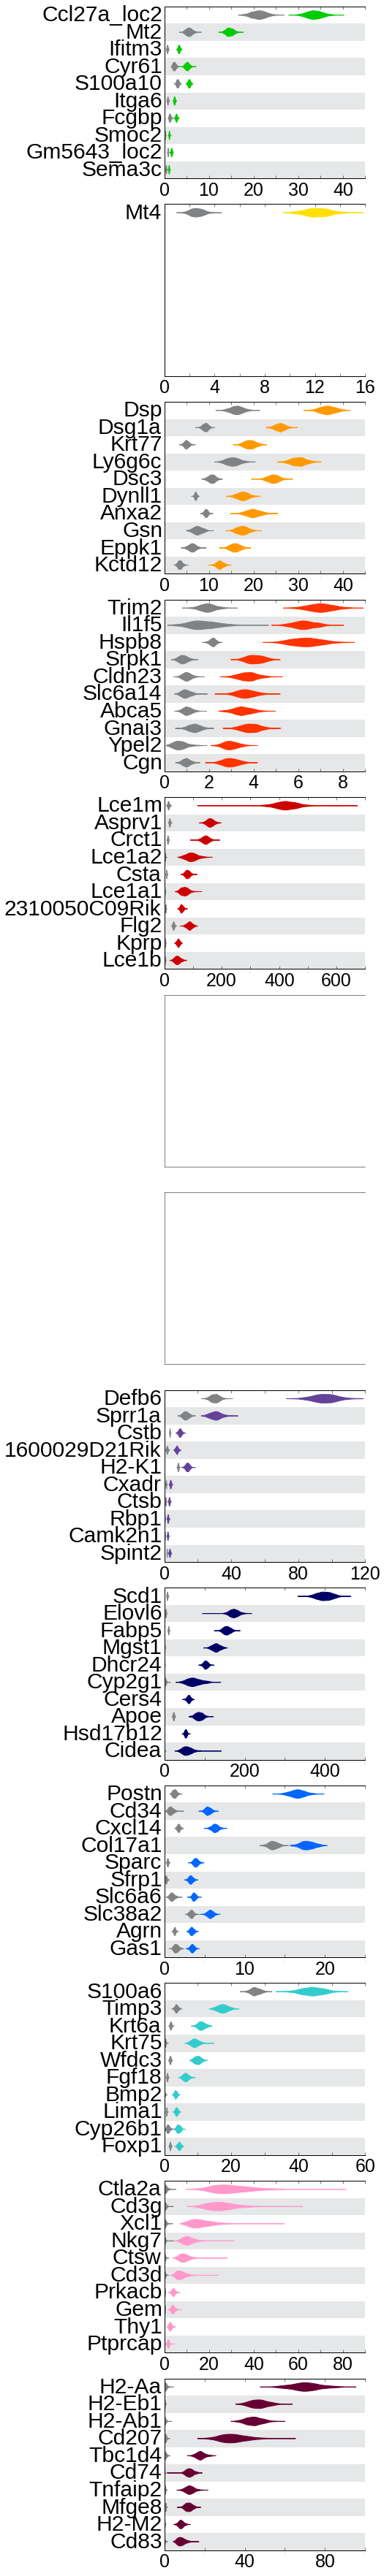

In [101]:
#define input variables

gr_order = return_unique(s_groups_1st)
genes = genes_groups
L = len(genes.index)
traces = NBR_1st_traces
summary = NBR_1st_summary
cmap = cmap_1st

#initialize figure

height = 4.8 * len(gr_order)
width = 8

plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(len(gr_order), 2, hspace = 0.15, wspace = 0.0, width_ratios = [5,8])

#iterate through groups

for pos, gr in enumerate(gr_order):
    
    genes_tmp = [gene for gene in genes[str(gr)].values if pd.isnull(gene) == False]
    
    #create gene name axis 
    
    ax0 = plt.subplot(gs[pos,0])
    ax0.set_ylim(L - 0.5, -0.5)
    clean_axis(ax0)
    
    #create violin plot axis
    
    ax1 = plt.subplot(gs[pos,1])
    
    ax1.spines['right'].set_color('none')

    ax1.set_ylim(L - 0.5, -0.5)
    ax1.yaxis.set_ticks_position('left')
    ax1.yaxis.set_ticks([])
    
    if len(genes_tmp) == 0:
        
        remove_ticks(ax1)
    
    #iterate over genes
    
    for ix, g in enumerate(genes_tmp):
        ax0.text(0.975, ix, g, family = 'Liberation Sans', fontsize = 30, ha = 'right', va = 'center')
        
        #print background
        
        if ix % 2 == 0:
            ax1.axhspan(ix - 0.5, ix + 0.5, color = '#FFFFFF', zorder = 0)
            
        if ix % 2 == 1:
            ax1.axhspan(ix - 0.5, ix + 0.5, color = '#E6E7E8', zorder = 0)
            
        #print group traces
        
        violin = ax1.violinplot([x - 1 for x in traces.ix[g, str(gr)]],
                       positions = [ix],
                       vert=False,
                       showextrema=False)
        
        for v in violin['bodies']:
            v.set_edgecolor(cmap[gr])
            v.set_facecolor(cmap[gr])
            v.set_linewidth(1.0)
            v.set_alpha(1.0)
            
        #print 2nd group traces
        
        gr_2nd = summary.ix[g].ix['mean'].order().index[-2]
        
        violin = ax1.violinplot([x - 1 for x in traces.ix[g, gr_2nd]],
                       positions = [ix],
                       vert=False,
                       showextrema=False)
        
        for v in violin['bodies']:
            v.set_edgecolor('#808284')
            v.set_facecolor('#808284')
            v.set_linewidth(1.0)
            v.set_alpha(1.0)

    for ix, t in enumerate(ax1.xaxis.get_ticklabels()):
        if ix % 2 == 0:
            t.set_family('Liberation Sans')
            t.set_fontsize(25)
        else:
            t.set_fontsize(0)
            
figname = 'v1.8_S2_H_Markers_vs_Groups.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# Marker gene barplots

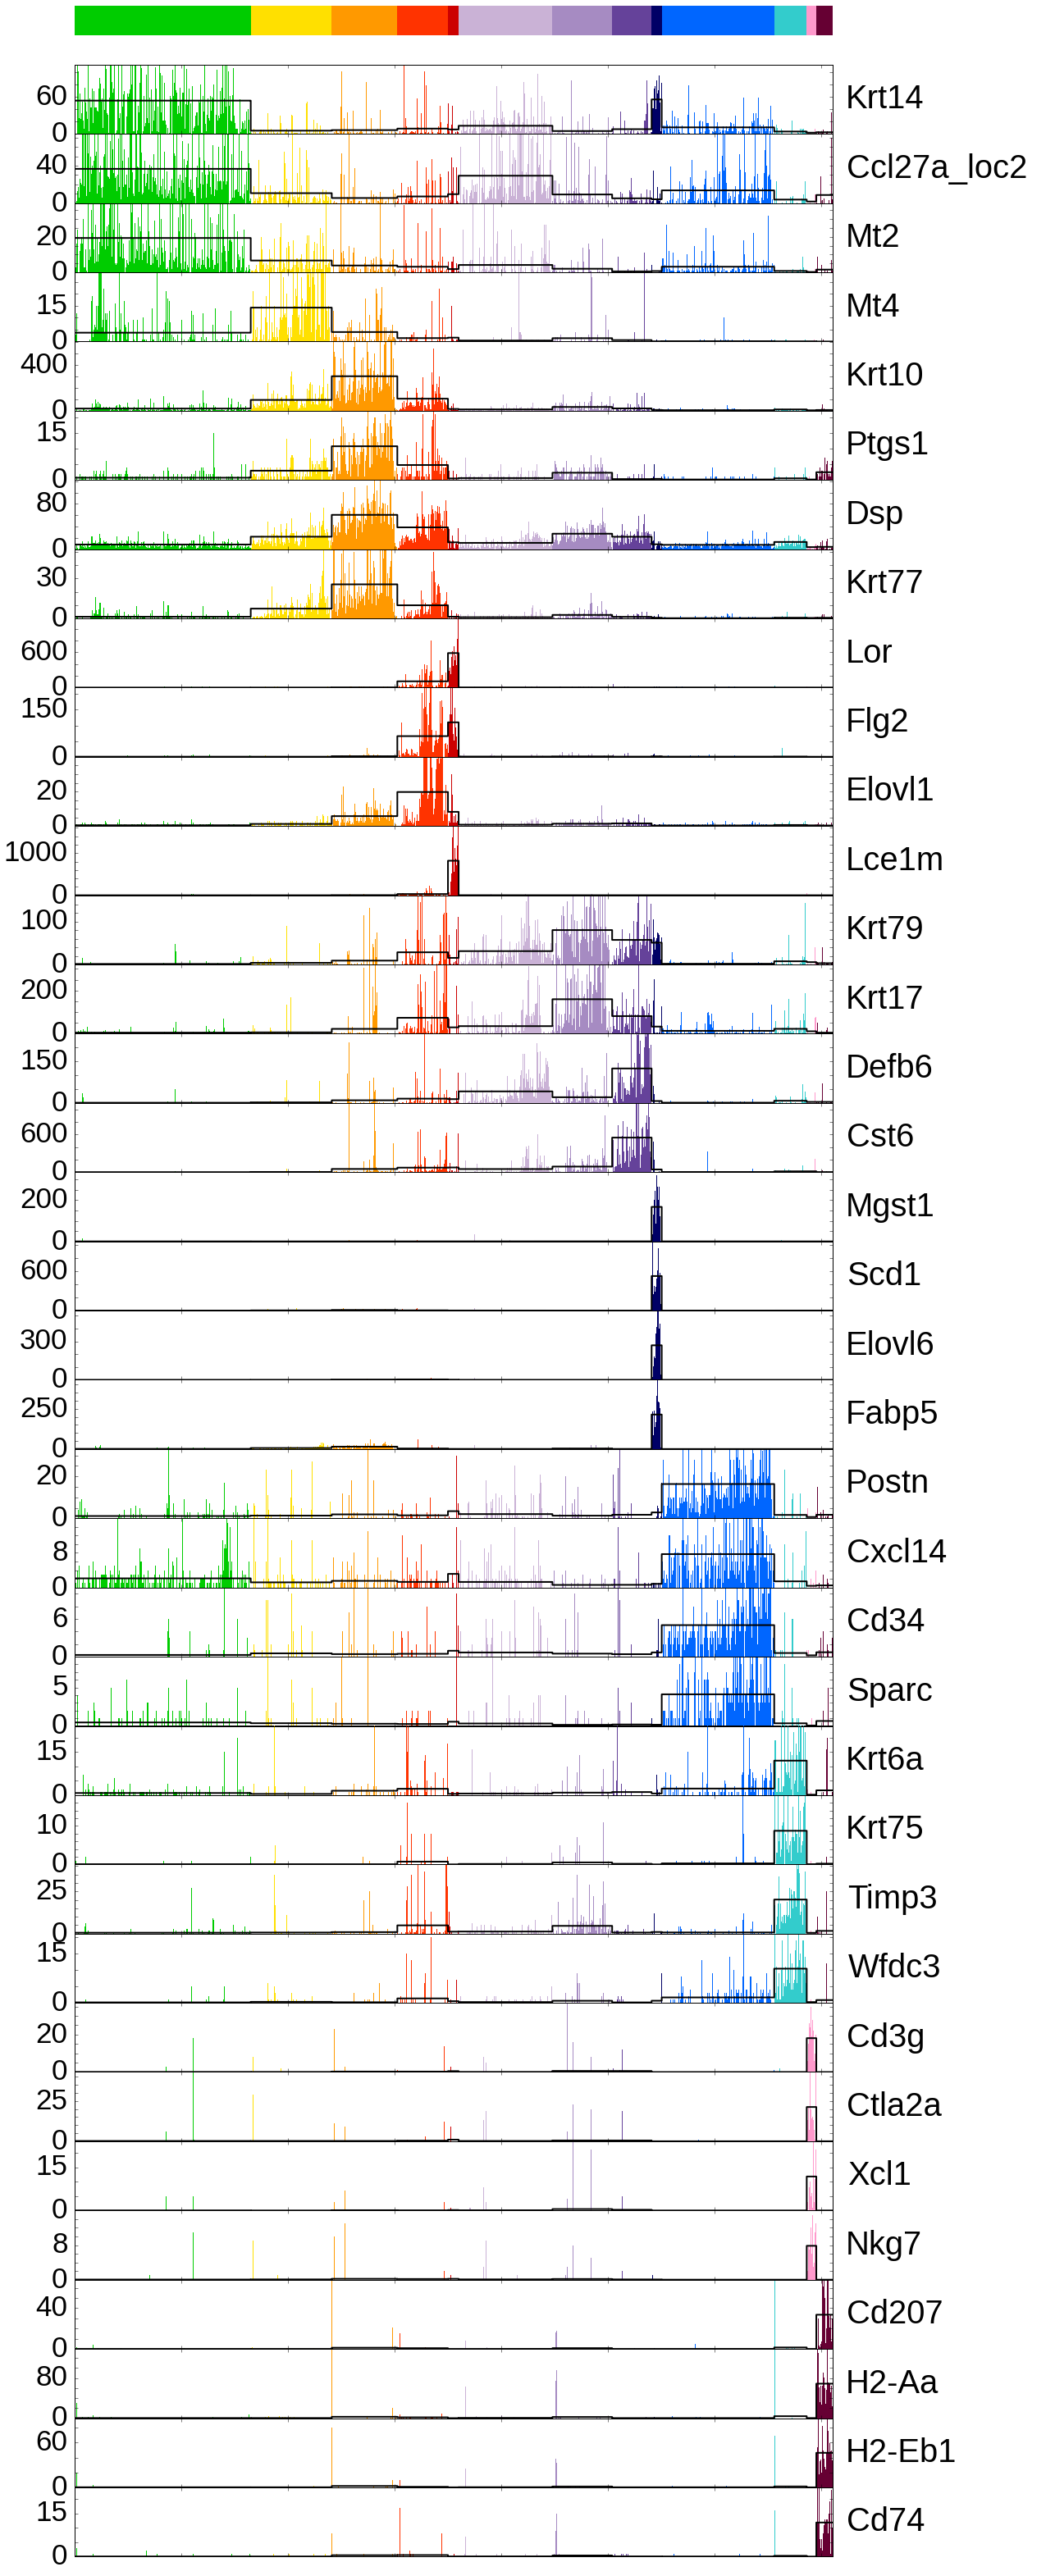

In [98]:
genes = ['Krt14','Ccl27a_loc2','Mt2','Mt4',
         'Krt10','Ptgs1','Dsp','Krt77',
         'Lor','Flg2','Elovl1','Lce1m',
         'Krt79','Krt17','Defb6','Cst6',
         'Mgst1','Scd1','Elovl6','Fabp5',
         'Postn','Cxcl14','Cd34','Sparc',
         'Krt6a','Krt75','Timp3','Wfdc3',
         'Cd3g','Ctla2a','Xcl1','Nkg7',
         'Cd207','H2-Aa','H2-Eb1','Cd74']

cell_groups = s_groups_1st
dataset = seq[s_groups_1st.index]
cmap = cmap_1st

#create figure

bar_size = 0.5
bar_pad = 0.5
width = 17.5
height = len(genes) * 1.2 #+ (bar_size + bar_pad)

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#create GS for gene barplots

gs1 = plt.GridSpec(len(genes), 2, hspace = 0.00, wspace = 0.0, top = 1 - ((bar_pad + bar_size) / height), right = 1, 
                   left = (bar_pad + bar_size) / width, bottom = 0, width_ratios = [14,4])

#create GS for sample group bar

gs0 = plt.GridSpec(1,2, left = (bar_pad + bar_size) / width, right = 1, top = 1,
                       bottom = 1 - ((bar_size) / height), hspace = 0.0, wspace = 0.0, width_ratios = [14,4])

#colorlist bar

clistBAR = [cmap[val] for val in cell_groups]

#draw genes

for g in genes:
    
        #create group_specific mean expressions
    
        mean_tmp = pd.Series(index = set(cell_groups))
        
        for gr in set(cell_groups):
            
            ix_tmp = cell_groups[cell_groups == gr].index
            mean_tmp[gr] = dataset.ix[g, ix_tmp].mean()
            
        #create white space for gene names
        
        ax0 = plt.subplot(gs1[genes.index(g),1])
        clean_axis(ax0)
 
        #create axis
            
        ax0 = plt.subplot(gs1[genes.index(g),0])
        
        ax0.axvspan(0, len(dataset.columns), color = '#FFFFFF', zorder = 0)
        
        #define xaxis
        
        ax0.set_xlim(left = 0, right = (len(dataset.columns)))
        ax0.xaxis.set_ticklabels([])
        
        #define yaxis
        
        ax0.set_ylim(bottom = 0, top = np.ceil(np.max(mean_tmp) * 2))
        ax0.set_ylabel(g, family = 'Liberation Sans', fontsize = 40, rotation = 'horizontal', va = 'center', ha = 'left')
        ax0.yaxis.set_label_coords(1.02, 0.5)
        
        for tick_pos in range(len(ax0.yaxis.get_major_ticks())):
            if tick_pos == 0 or tick_pos == len(ax0.yaxis.get_major_ticks()) / 2:
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_family('Liberation Sans')
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_fontsize(35)
            else:
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_visible(False)
                
        #draw expression data
        
        ax0.bar(np.arange(0, len(dataset.columns),1), dataset.ix[g], color = clistBAR, linewidth = 0, width = 1.0)
        
        #draw means
        
        ax0.step(range(len(cell_groups)), [mean_tmp[val] for val in cell_groups], where = 'post', color = 'black', linewidth = 2)

ax1 = plt.subplot(gs0[0,0])

ax1.set_xlim(0, len(cell_groups))

for s_gr in enumerate(cell_groups):
    
    ax1.axvspan(xmin = s_gr[0], xmax = s_gr[0] + 1, color = cmap[s_gr[1]])

remove_ticks(ax1, linewidth = 1)
clean_axis(ax1)

figname = 'v1.8_S2_I_Barplot.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# Save 1st level neg. binominal regression data to txt file

In [31]:
seq_ = dropNull(seq, path_input, cutoff_mean = 0.00)


Dropping spikes from dataset

Dropping repeats from dataset

Dropping unexpressed genes from dataset


In [53]:
m_ix1, m_ix2 = [],[]

for gr in return_unique(s_groups_1st):
    m_ix1 += [nmap_1st_short[gr]] * 2
    m_ix2 += ['vs Baseline','vs other groups']
    
NBR_1st_excel = pd.DataFrame(index = seq_.index, columns = [np.array(m_ix1), np.array(m_ix2)])

ix_sel = NBR_1st_size_bl.index.levels[0]

for gr in return_unique(s_groups_1st):
    
    NBR_1st_excel[nmap_1st_short[gr], 'vs Baseline'].ix[ix_sel] = NBR_1st_size_bl.swaplevel(0,1).ix['percentile - 25'].ix[ix_sel][str(gr)]
    NBR_1st_excel[nmap_1st_short[gr], 'vs other groups'].ix[ix_sel] = NBR_1st_size_gr.swaplevel(0,1).ix['percentile - 25'].ix[ix_sel][str(gr)]
    
NBR_1st_excel[NBR_1st_excel=='n.s'] = 'n.s.'
NBR_1st_excel = NBR_1st_excel.fillna('b.c.')

In [64]:
#saveData_v1(NBR_1st_excel, path_output, exp_id, 'NBR_1st_excel')